In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, ensemble
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='whitegrid', font_scale=1.3)

In [2]:
#set seaborn plot display options
sns.set(style='whitegrid', palette='muted', font_scale=1.3)

#color variables incase they're needed
color_b = sns.color_palette('muted').as_hex()[0]
color_g = sns.color_palette('muted').as_hex()[1]
color_r = sns.color_palette('muted').as_hex()[2]
color_p = sns.color_palette('muted').as_hex()[3]
color_y = sns.color_palette('muted').as_hex()[4]
color_c = sns.color_palette('muted').as_hex()[5]

# ¡ Change intro to reflect new project !

# 0. Introduction

## 0.1 Research Proposal
- __Research Question:__ Can we use residential property sales data to predict the financial crisis$^1$ (& the recovery)?
- Why is this a good question to study?
- What are some challenges to this question?
- *fill in with some more recession info, any relevent details that come up and have nowhere else to go, etc*

$^1$ Using NBER dates for great recession: Dec 2007 - June 2009 [source](https://www.nber.org/cycles.html)

## 0.2 Method
1. Develop a model to predict saleprice; will also establish a level of predictive power to compare with later
2. Apply and train only using pre-crisis data
3. Test on crisis data, goal being to predict the recession (& later the recovery)m

# 1. Dataset: Ames, Iowa Housing Market Data

## 1.1 Dataset background

__Abstract Excerpt:__

This paper presents a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

__Full Description:__

https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

__Data Source:__

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Kaggle API: >_ kaggle competitions download -c house-prices-advanced-regression-techniques

## 1.2 Upload Data

In [3]:
train_raw = pd.read_csv('train.csv')
#train_raw.head()

In [4]:
#train_raw.describe()

In [5]:
#train_raw.columns

## 2.1 Basic Cleaning

In [48]:
#set df to manipulate, leave raws accessible
train = train_raw.copy()

#lowercase column names
train.columns = [x.lower() for x in train.columns]

#strip whitespace
to_strip = train.select_dtypes(include='object')
train[to_strip.columns] = to_strip.apply(lambda x: x.str.strip())

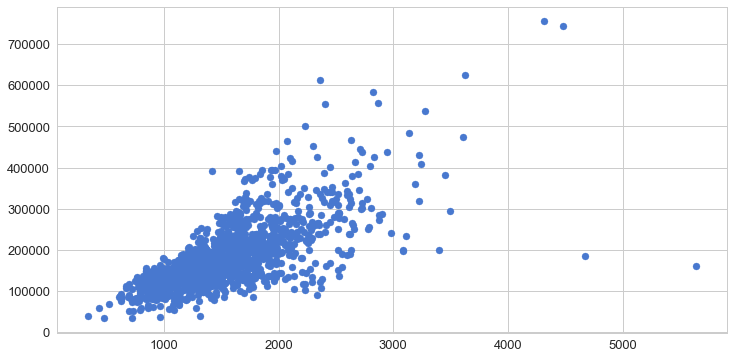

In [49]:
plt.figure(figsize=(12,6))
plt.scatter(train['grlivarea'], train['saleprice'])
plt.show()

In [50]:
train = train[train.grlivarea < 4000]
print(train.grlivarea.max())

3627


## 2.3 Missingness

In [51]:
#see whats missing
missing_data = train.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index()
missing_data.columns = ['variable','rows_missing']
missing_data = missing_data[missing_data['rows_missing'] > 0]
missing_data

,variable,rows_missing
0,poolqc,1451
1,miscfeature,1402
2,alley,1365
3,fence,1176
4,fireplacequ,690
5,lotfrontage,259
6,garagecond,81
7,garagetype,81
8,garageyrblt,81
9,garagefinish,81


__NA indicates lack of feature:__ impute no_feature or 0 (descriptions are available in the 'data_description.txt' file)
- poolqc: pool quality
- miscfeature: miscellaneous feature not covered in other categories
- alley: type of alley access to property
- fence: fence quality
- fireplacequ: fireplace quality
- garagecond: garage condition
- garagetype: garage location
- garageyrblt: year garage was built
- garagefinish: interior finish of garage
- garagequal: garage quality
- bsmtexposure: refers to walkout or garden level walls
- bsmtfintype1: rating of basement finished area
- bsmtfintype2: rating of basement finished area (if multiple types)
- bsmtcond: evaluates the general condition of the basement
- bsmtqual: evaluates the height of the basement (in inches, Excellent >= 100, Poor < 70)
- masvnrtype: masonry veneer type
- masvnrarea: masonry veneer area in square feet

In [52]:
#handle missing values, easy part
train['poolqc'].fillna('no_pool', inplace=True)
train['miscfeature'].fillna('no_miscfeat', inplace=True)
train['alley'].fillna('no_access', inplace=True)
train['fence'].fillna('no_fence', inplace=True)
train['fireplacequ'].fillna('no_fireplace', inplace=True)
train['garagecond'].fillna('no_garage', inplace=True)
train['garagetype'].fillna('no_garage', inplace=True)
train['garagefinish'].fillna('no_garage', inplace=True)
train['garagequal'].fillna('no_garage', inplace=True)
train['garageyrblt'].fillna(0, inplace=True)
train['bsmtexposure'].fillna('no_bsmt', inplace=True)
train['bsmtfintype1'].fillna('no_bsmt', inplace=True)
train['bsmtfintype2'].fillna('no_bsmt', inplace=True)
train['bsmtcond'].fillna('no_bsmt', inplace=True)
train['bsmtqual'].fillna('no_bsmt', inplace=True)
train['masvnrtype'].fillna('no_masvnr', inplace=True)
train['masvnrarea'].fillna(0, inplace=True)

#### Special Case 1

electrical: electrical system, can be one of the following
- SBrkr: Standard Circuit Breakers & Romex
- FuseA: Fuse Box over 60 AMP and all Romex wiring (Average)	
- FuseF: 60 AMP Fuse Box and mostly Romex wiring (Fair)
- FuseP: 60 AMP Fuse Box and mostly knob elect & tube wiring (poor)
- Mix: Mixed

In [53]:
print(train['electrical'].value_counts(dropna=False))

SBrkr    1330
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: electrical, dtype: int64


In [54]:
#impute with most common value
train['electrical'].fillna('SBrkr', inplace=True)
print(train['electrical'].value_counts(dropna=False))

SBrkr    1331
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: electrical, dtype: int64


#### Special Case 2
lotfrontage: linear feet of street connected to property, 

In [55]:
print(train['lotfrontage'].value_counts(
    dropna=False).sort_values(ascending=False).head())

NaN      259
 60.0    143
 70.0     70
 80.0     69
 50.0     57
Name: lotfrontage, dtype: int64


Hard to believe that 259 residential properties were sold without connecting to a street
- check against street
- check against lotarea
- come up with strategy to impute

In [56]:
print(train['street'].isnull().sum())
print(train['lotarea'].isnull().sum())

0
0


- Variables street and lotarea have no missing values
- lotfrontage nulls should be filled with something
- investigate the relationship between lotfrontage and lotarea

In [57]:
temp_df = train.loc[:, (train.columns).isin(['lotfrontage', 'lotarea'])]
temp_df['ratio'] = temp_df['lotfrontage'] / temp_df['lotarea']

print('ratio mean: %.5f' % temp_df['ratio'].dropna().mean())
print('ratio median: %.5f' % temp_df['ratio'].dropna().median())
print('ratio mode: %.5f' % temp_df['ratio'].dropna().mode())

ratio mean: 0.00791
ratio median: 0.00771
ratio mode: 0.00833


- Mean, median, and mode are all about 0.008
- Impute lotfrontage nulls with their lotarea * mean ratio to estimate lotfrontage

In [58]:
ratio_mean = (train['lotfrontage'] / train['lotarea']).mean()
train['lotfrontage'].fillna(train['lotarea'] * ratio_mean, inplace=True)
train['lotfrontage'].isnull().sum()

0

## 2.4 Target Variable Distribution

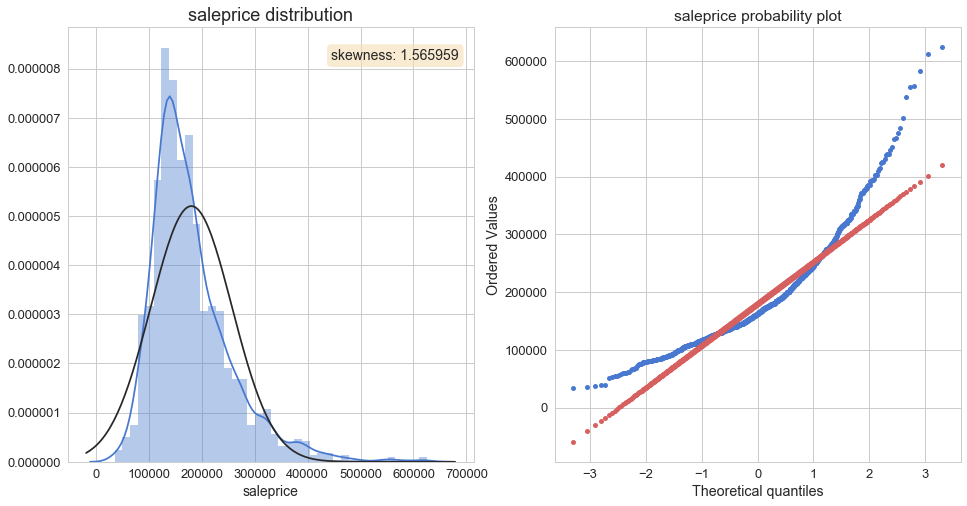

NormaltestResult(statistic=460.3067960010808, pvalue=1.1108342380647651e-100)


In [59]:
plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
sns.distplot(train['saleprice'], ax=ax1, fit=norm)
ax1.set_xlabel('saleprice', size=14)
ax1.set_title('saleprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skewness: %f' % (train['saleprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(122)
stats.probplot(train['saleprice'], plot=ax2)
ax2.set_title('saleprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor(color_b)
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor(color_r)
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=train['saleprice']))

- saleprice is pretty far from normally distributed
- See how log transformation looks

In [60]:
print('log:', stats.normaltest(a=np.log(train['saleprice'])))

log: NormaltestResult(statistic=17.417871145375766, pvalue=0.0001651039020773473)


- Log transforming saleprice results in a much more normal distribution

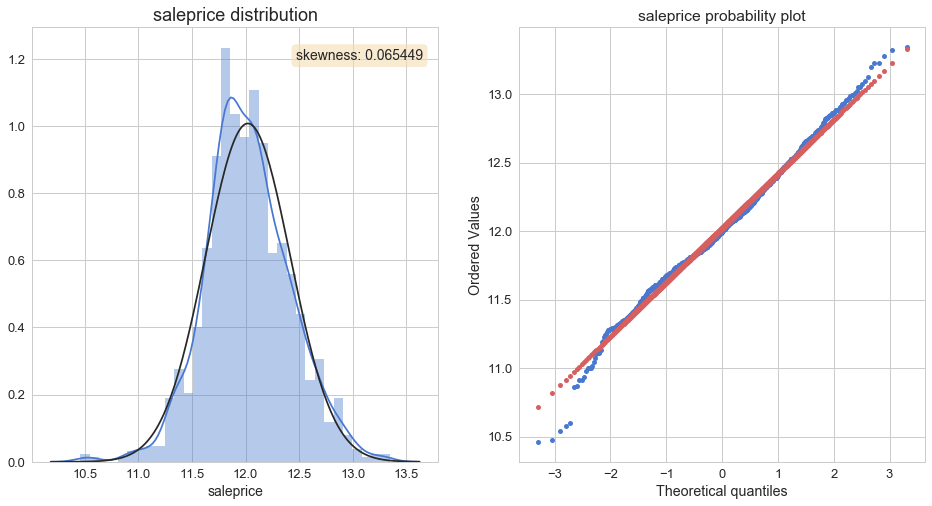

NormaltestResult(statistic=17.417871145375766, pvalue=0.0001651039020773473)


In [61]:
train['saleprice'] = np.log(train['saleprice'])

plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
sns.distplot(train['saleprice'], ax=ax1, fit=norm)
ax1.set_xlabel('saleprice', size=14)
ax1.set_title('saleprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skewness: %f' % (train['saleprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(122)
stats.probplot(train['saleprice'], plot=ax2)
ax2.set_title('saleprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor(color_b)
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor(color_r)
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=train['saleprice']))

## Feature Selection/Engineering

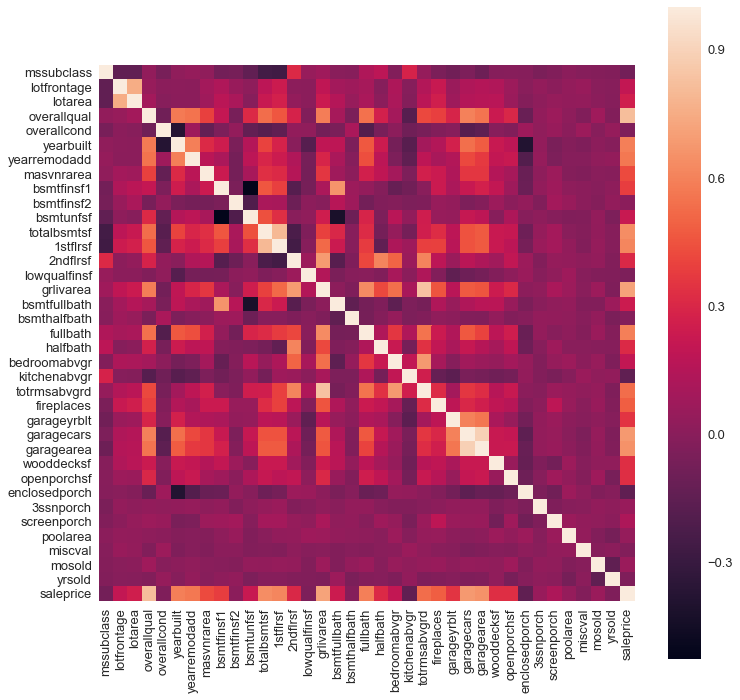

In [62]:
#drop id column, no helpful data just record ids
train = train.drop(['id'], 1)
corrmat = train.corr()

plt.figure(figsize=(12,12))
sns.heatmap(corrmat, square=True)
plt.show()

In [63]:
feats_corr = corrmat['saleprice'].sort_values(ascending=False).tail(-1)
feats_corr = feats_corr[feats_corr > 0]
#feats_corr

- Square footage is understandably positively correlated with saleprice: create new total ft^2 features which more closely resemble how houses are listed anyway
- garagecars and garagearea say essentially the same thing, drop one (will use garagearea in new features and drop, garagecars has higher correlation with saleprice anyway and is a better measure of garage usefulness)

In [64]:
#make sure current sf variables add up as expected
print((train['bsmtfinsf1'] + train['bsmtfinsf2'] + train['bsmtunfsf'] == train['totalbsmtsf']).value_counts())
print((train['1stflrsf'] + train['2ndflrsf'] + train['lowqualfinsf'] == train['grlivarea']).value_counts())

True    1456
dtype: int64
True    1456
dtype: int64


In [65]:
train['totalsf'] = train['totalbsmtsf'] + train['grlivarea']
train['totalsf_with_garage'] = train['totalsf'] + train['garagearea']

In [66]:
#drop old features
#train = train.loc[:, ~(train.columns).isin(['bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
#           '1stflrsf', ' 2ndflrsf', 'lowqualfinsf', 'grlivarea', 'garagearea'])]

mosold and yrsold are separate, make new feature that combines them

In [67]:
train['mosold'] = train['mosold'].apply('{:0>2}'.format)
train['yrmo_sold'] = train.yrsold.astype(
    str).str.cat(train.mosold.astype(str)).astype(int)

## Prepare for modeling

In [68]:
train = pd.get_dummies(train)

In [69]:
X = train.loc[:, ~(train.columns).isin(['saleprice'])]
y = train['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

cv = 5

def rmse_train(model):
    rmse_train = np.sqrt(-cross_val_score(model, X_train, y_train, cv=cv,
                                          scoring='neg_mean_squared_error'))
    return(rmse_train.mean())

def rmse_test(model):
    rmse_test = np.sqrt(-cross_val_score(model, X_test, y_test, cv=cv,
                                         scoring='neg_mean_squared_error'))
    return(rmse_test.mean())

# Modeling

## Regularized Linear Regressions

## L2/Ridge

In [70]:
#broad alpha search
ridge = RidgeCV(alphas=[0.01, 0.025, 0.05, 0.075,
                0.1, 0.25, 0.5, 0.075,
                1, 2.5, 5, 7.5,
                10, 25, 50])

ridge.fit(X_train, y_train)
print('model: ridge')
print('alpha: ', ridge.alpha_)
print('train rmse: ', rmse_train(ridge))
print('test rmse: ', rmse_test(ridge))
print('test - train = ', rmse_test(ridge) - rmse_train(ridge))

model: ridge
alpha:  25.0
train rmse:  0.1179515550533182
test rmse:  0.12813485111616338
test - train =  0.010183296062845182


In [71]:
#seemingly at random, integer alphas need to be typed as a float (25.0) or:
#ValueError: Integers to negative integer powers are not allowed.

#tune alpha some more
alphas = [25.0, 15, 20, 30, 40]
ridge = RidgeCV(alphas=alphas)

ridge.fit(X_train, y_train)
print('model: ridge')
print('alpha: ', ridge.alpha_)
print('train rmse: ', rmse_train(ridge))
print('test rmse: ', rmse_test(ridge))
print('test - train = ', rmse_test(ridge).mean() - rmse_train(ridge).mean())

model: ridge
alpha:  25.0
train rmse:  0.11764854900755624
test rmse:  0.1275500015264235
test - train =  0.009901452518867274


## L1/Lasso

In [72]:
lasso = LassoCV(alphas=[0.0001, 0.0005,
                        0.001, 0.005, 
                        0.01, 0.05, 
                        0.1, 0.5,
                        1, 5])

lasso.fit(X_train, y_train)
print('model: lasso')
print('alpha:', lasso.alpha_)
print('train rmse:', rmse_train(lasso))
print('test rmse:', rmse_test(lasso))
print('test - train = ', rmse_test(lasso) - rmse_train(lasso))

model: lasso
alpha: 0.0005
train rmse: 0.11516186206576269
test rmse: 0.12801020942154256
test - train =  0.012848347355779874


In [73]:
#alphas = [0.001, 0.0006, 0.0007, 0.0008, 0.0009, 0.002, 0.003, 0.004]
alphas=[0.0005,0.0001, 0.0002, 0.0003, 0.0004,0.0006, 0.0007, 0.0008, 0.0009, 0.001]
lasso = LassoCV(alphas=alphas)
 
lasso.fit(X_train, y_train)
print('model: lasso')
print('alpha:', lasso.alpha_)
print('train rmse:', rmse_train(lasso))
print('test rmse:', rmse_test(lasso))
print('test - train = ', rmse_test(lasso) - rmse_train(lasso))

model: lasso
alpha: 0.0007
train rmse: 0.11503095574675157
test rmse: 0.12429317489128551
test - train =  0.009262219144533942


## Ensemble Models

## Random Forest Regressor

In [74]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 97 to 1266
Columns: 316 entries, mssubclass to salecondition_Partial
dtypes: float64(3), int64(35), uint8(278)
memory usage: 629.2 KB


In [75]:
rfr = ensemble.RandomForestRegressor()
params = [{'n_estimators':[10, 50, 100, 250, 500],
           'max_features':[100, 200, 308],
           'max_depth':[10,20,30,40]}]

start_time = time.clock()
grid = GridSearchCV(estimator=rfr,
                    param_grid=params,
                    scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)
print('params:', grid.best_params_)
print('runtime: ', time.clock() - start_time)

params: {'max_depth': 20, 'max_features': 100, 'n_estimators': 50}
runtime:  327.84792699999997


In [76]:
rfr = ensemble.RandomForestRegressor(n_estimators=50, max_features=100, max_depth=20)

start_time = time.clock()
rfr.fit(X_train, y_train)

print('model: random forest')
print('train rmse:', rmse_train(rfr))
print('test rmse:', rmse_test(rfr))
print('test - train = ', rmse_test(rfr) - rmse_train(rfr))
print('runtime: ', time.clock() - start_time)

model: random forest
train rmse: 0.13886038126897943
test rmse: 0.1468905890804219
test - train =  0.010359771013712993
runtime:  5.622653000000014


## XGBoost
First time using this

In [77]:
from xgboost import XGBRegressor

xgb_rgr = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_rgr.fit(X_train, y_train, early_stopping_rounds=5,
            eval_set=[(X_test, y_test)], verbose=False)

print('model: xgboost regressor')
print('train rmse:', rmse_train(xgb_rgr))
print('test rmse:', rmse_test(xgb_rgr))
print('test - train = ', rmse_test(xgb_rgr) - rmse_train(xgb_rgr))
print('runtime: ', time.clock() - start_time)

model: xgboost regressor
train rmse: 0.11715713377768991
test rmse: 0.1436728850657151
test - train =  0.02651575128802519
runtime:  65.01749699999999


In [78]:
xgb_rgr = XGBRegressor()

params = [{'max_depth':[3],
           'learning_rate':[0.1, 0.05, 0.01],
           'subsample':[0.25, 0.5, 0.75, 1]}]

start_time = time.clock()
grid = GridSearchCV(estimator=xgb_rgr,
                    param_grid=params,
                    scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)
print('params:', grid.best_params_)
print('runtime: ', time.clock() - start_time)

params: {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1}
runtime:  11.494575999999995


In [79]:
xgb_rgr = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3, subsample=1)
xgb_rgr.fit(X_train, y_train, early_stopping_rounds=5,
            eval_set=[(X_test, y_test)], verbose=False)

print('model: xgboost regressor')
print('train rmse:', rmse_train(xgb_rgr))
print('test rmse:', rmse_test(xgb_rgr))
print('test - train = ', rmse_test(xgb_rgr) - rmse_train(xgb_rgr))
print('runtime: ', time.clock() - start_time)

model: xgboost regressor
train rmse: 0.11794132498216484
test rmse: 0.14239679484820084
test - train =  0.024455469866036
runtime:  67.76732800000008
